# Modelos usando el algoritmo de arboles de decisión

# Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import preprocessing
import informe
import sklearn
from sklearn.model_selection import train_test_split
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [13]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,Palermo,relacion_de_dependencia,27,universidad_2_anio,matrimonio_civil,0,mujer,38,cristianismo,casada,0,soporte_tecnico
32557,13,Palermo,relacion_de_dependencia,40,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector
32558,13,Palermo,relacion_de_dependencia,58,4_anio,viudo_a,0,mujer,40,cristianismo,soltero_a,0,entretenimiento
32559,13,Palermo,relacion_de_dependencia,22,4_anio,sin_matrimonio,0,hombre,20,cristianismo,con_hijos,0,entretenimiento


# Llamado a funciones de preprocesamiento

## Conversión de variables
- Hay que convertir todos los features categóricos a númericos. Para variables categóricas se usarán Dummy Variables y para ordinales OrdinalEncoder.

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, X_test, scalar = preprocessing.escalar(X_train, X_test)

# Modelos

## Modelo 1

In [4]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model = Sequential()
model.add(Dense(8, input_shape=(40,), activation='tanh', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[custom_early_stopping, mc],
    verbose=0
)

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Gráfico de accuracy de train y test para verificar que no haya overfitting.

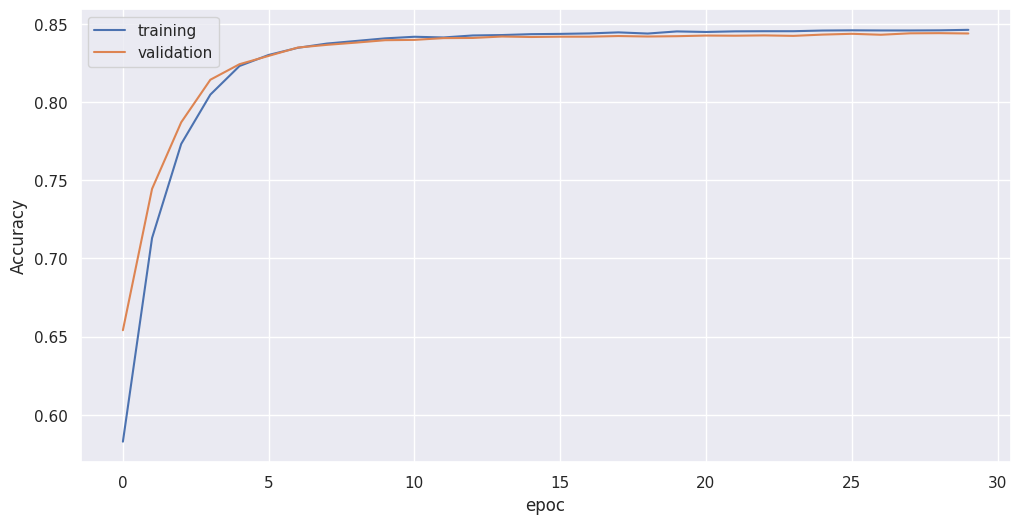

In [5]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

### Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.8438939502507933 
Precision: 0.7118987341772152 
Recall: 0.9231807749426219 
F1-score: 0.6483744523864422 

Curva ROC-AUC:


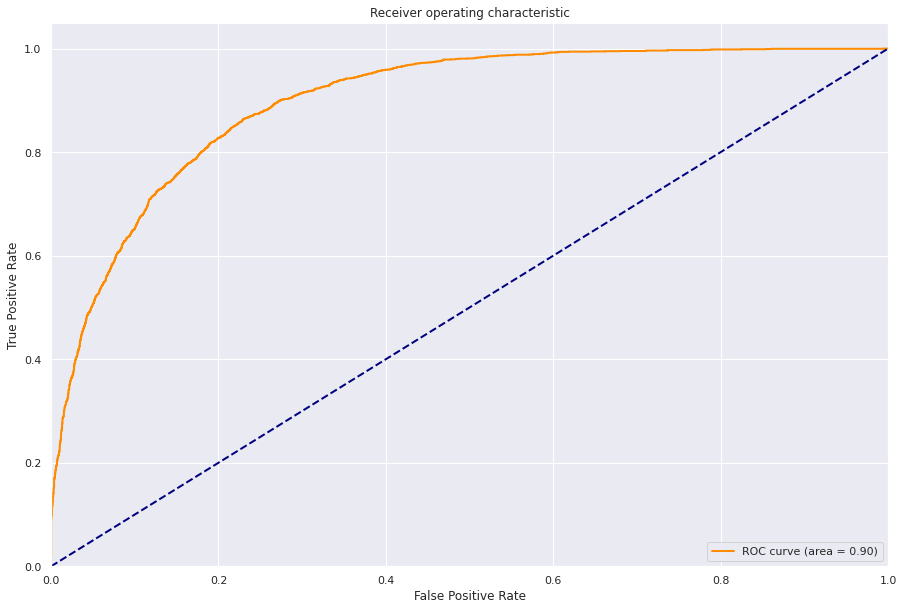

In [6]:
from sklearn.metrics import plot_roc_curve

y_proba = model.predict(X_test)
y_pred = model.predict_classes(X_test)
informe.imprimir_metricas_red(y_test, y_pred)
print("Curva ROC-AUC:")
informe.plot_roc(model, X_test, y_test, classifier=False, y_proba=y_proba)

# Conclusión
      
### Informe del modelo 2 usando los datos del test_holdout

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


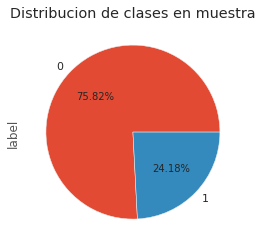

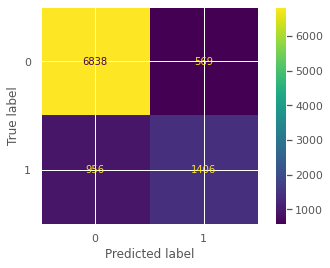

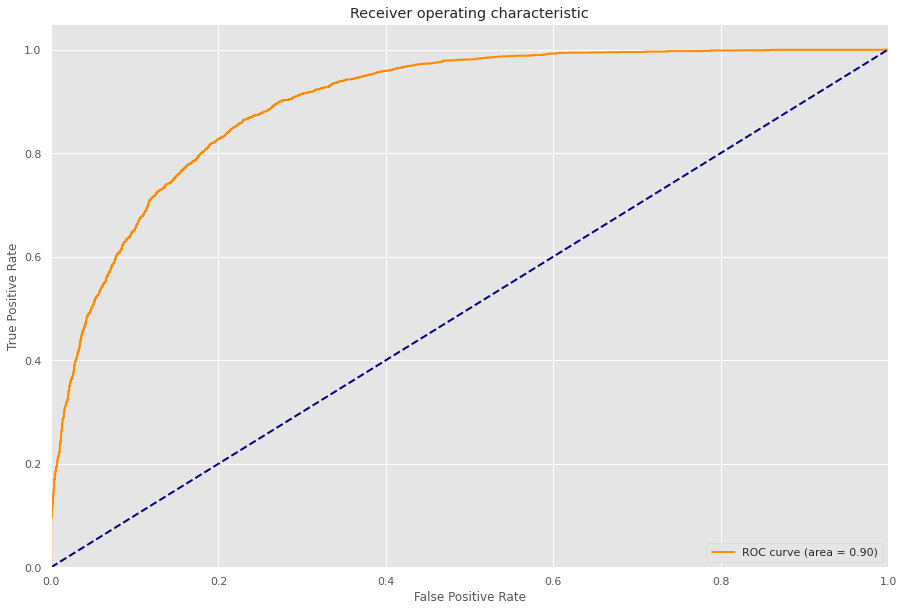

Métricas:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7407
           1       0.71      0.60      0.65      2362

    accuracy                           0.84      9769
   macro avg       0.79      0.76      0.77      9769
weighted avg       0.84      0.84      0.84      9769



In [7]:
y_pred = model.predict_classes(X_test)

informe.plt_distribucion_de_clases(y_test)
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred)).plot()
informe.plot_roc(model, X_test, y_test, classifier=False, y_proba=y_proba)
print('Métricas:')
print(sklearn.metrics.classification_report(y_test, y_pred))

## Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 84%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        La fracción de predicciones de 0's que realmente eran 0's fue de aproximadamente 88% y la fracción de predicciones de 1's que realmente eran 1's fue del 71% 


- recall:

        Los 0's reales detectados fueron aproximadamente del 92%, y los 1's reales detectados fueron del 60%. Se ve que el modelo tiene un buen recall y precisión.
        

- f1 score:
   
       Este resultado da una idea de la calidad del recall y la precision asi como el balance entre ellos.
       
       
- matriz de confusion:

        Se puede ver que la cantidad de falsos negativos y falsos positivos fue similar. Sin embargo, la mayoría de las predicciones están en la diagonal.
        
        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases en un 90%. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [12]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.one_hot_encodding(df_test)
df_test = scalar.transform(df_test)

y_pred = model.predict_classes(df_test)
informe.save_pred(y_pred, 'red_neuronal')

/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
